In [150]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

In [151]:
SAVE_DIR = 'media/'
%mkdir -p /media/final
X_LIM = (-2, 0.5)
Y_LIM = (-1, 1)

mkdir: /media: Read-only file system


In [152]:
# Checking if a point is part of the mandelbrot set
@jit(nopython=True)
def mandelbrot(z, max_iter):
    c = z
    for i in range(max_iter):
        if np.abs(z) > 2:
            return i
        z = z*z + c
    return max_iter

# Utility for plotting
def plot_mandelbrot(c_points, counts, max_iter=250, gen_type='fixed', save=True, show=True):
    N = int(np.sqrt(len(counts)))
    match(gen_type):
        case 'fixed':
            pixel_values = counts.reshape(N, N)
        case 'mc':
            return
        case _:
            return
    plt.imshow(pixel_values, cmap='hot', extent=[*X_LIM, *Y_LIM])
    plt.colorbar(shrink=0.85, label='# iterations')
    plt.axis('off')
    if save:
        plt.savefig(f'mandelbrot_{gen_type}_{max_iter}_{N}.png', dpi=300)
    if show:
        plt.show()

# Generating mandelbrot set on a fixed grid
@jit(nopython=True, parallel=True)
def mandelbrot_parallel_fixed(max_iter=250, size=5_000):
    real_parts = np.linspace(*X_LIM, size)
    imag_parts = np.linspace(*Y_LIM, size)
    c_points = np.zeros((size, size), dtype=np.complex128)
    counts = np.zeros((size, size), dtype=np.int32)
    for i in prange(size):
        for j in prange(size):
            z = complex(real_parts[j], imag_parts[i])
            c_points[i, j] = z
            counts[i, j] = mandelbrot(z, max_iter)
    return c_points.flatten(), counts.flatten()

# Generating mandelbrot using monte-carlo randomly sampled points
@jit(nopython=True, parallel=True)
def mandelbrot_parallel_mc(max_iter=250, n_points=1_000_000):
    real_parts = np.random.uniform(low=X_LIM[0], high=X_LIM[1], size=n_points)
    imag_parts = np.random.uniform(low=Y_LIM[0], high=Y_LIM[1], size=n_points)
    c_points = np.stack((real_parts, imag_parts), axis=-1).view(np.complex128)
    counts = np.zeros((n_points), dtype=np.int32)
    for i in prange(n_points):
        z = c_points[i]
        counts[i] = mandelbrot(z, max_iter)
    return c_points, counts

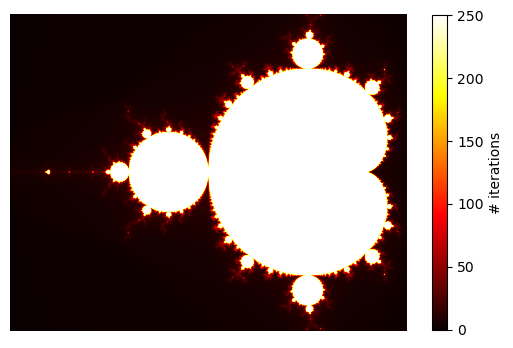

In [153]:
c_points, counts = mandelbrot_parallel_fixed()
plot_mandelbrot(c_points, counts)